## <ins>An EDA on sentiment analysis with financial news headlines </ins>
<br>

Is there any correlation between financial news headlines and stock prices? The connection between sentiment and stock would seem plausible enough given that investors are often influenced by what they read in the news and investors then affect prices. Additionally, sentiment is often used in forecasting stocks as one indicator (among others). The purpose here is not to try to forecast or predict anything but rather to see simply if there exists any correlation at all between news and stock price. This will give us the opportunity to explore some of Python's capabilities regarding various data science tasks, including: data mining, data wrangling, data visualisation, statistical analysis, as well as implementing a deep learning algorithm (for sentiment analysis). Sentiment analysis is itself a form of data mining in which opinions are sought from analysing portions of text. In what follows, we restrict our focus to financial news *headlines* only rather than entire articles. 


The steps covered in the following analysis are as follows: 

1. Retrieve financial **news headlines** from a large Kaggle dataset and then specify a small selection of stocks from a specific time period. We'll do a bit of filtering, data-cleaning and visualisation along the way. 
2. Retrieve the **stock prices** for the selected tickers for the specified time period using *Yahoo finance*. 
3. Preprocess the news data so that the publish date matches the business days of the stock exchange for the tickers. 
4. Perform **sentiment analysis** on the headlines with a pre-trained deep learning model, *finBERT*. 
5. Perform statistical analysis on the two time-series. Two parts to this:
    - Testing each time series for **stationarity** so as to avoid any *spurious* correlations. Then we perform some feature engineering to make the series stationary.
    - Perform a **cross correlation** test for correlation




We begin by importing our libraries that we will use in this EDA: 

In [5]:
# stock data gathering 
import pandas_datareader as pdr
import os

# headline data gathering
import pandas as pd

# visualisation 
from matplotlib import pyplot as plt 
from matplotlib import dates
from matplotlib import gridspec

# preprocessing
from pandas.tseries.offsets import BDay

# sentiment analysis 
from transformers import AutoTokenizer, AutoModelForSequenceClassification  
import torch
from transformers import pipeline

# statistical analysis 
import numpy as np
import math
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller 
import statsmodels.tsa.stattools as stattools


### Step 1: retrieve financial headlines
We need our financial headlines. We'll the use a large dataset that can be downloaded from [Kaggle](https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?select=analyst_ratings_processed.csv). Here it loaded as a .csv file from a local drive:  

In [6]:
headlines_df = pd.read_csv('analyst_ratings_processed.csv')

Let's examine the format of the data, as well as its shape:

In [7]:
headlines_df.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [7]:
headlines_df.shape

(1400469, 4)

We'll need the *title*, *date* and *stock* columns, but we can drop the *Unnamed: 0* column:

In [8]:
headlines_df = headlines_df.drop(['Unnamed: 0'], axis=1)

Check for null values: 

In [9]:
headlines_df.isna().sum()

title       0
date     1289
stock    2578
dtype: int64

There are some NaNs in the *date* column (the ones in the *stock* column won't worry us). We'll first coerce these to Pandas datetime objects, and then get rid of them as follows:

In [10]:
headlines_df['date'] = pd.to_datetime(headlines_df['date'], utc=True, errors='coerce')
headlines_df = headlines_df[headlines_df['date'].notna()]

In [11]:
headlines_df.isna().sum()

title    0
date     0
stock    0
dtype: int64

We want to restrict our focus to a fairly shortish period of time, say three months. We also want to avoid picking tickers with very few headlines over that period since then we'll have very sparse data. Therefore let's choose a period and see which tickers have the most headlines during that period: 

In [12]:
a = headlines_df.loc[headlines_df['date']>='2019-11-01']
a = a.loc[headlines_df['date']<='2020-02-01']
a['stock'].value_counts()[0:20]

TSLA     550
NFLX     242
GOOGL    213
PCG      195
NIO      180
GOOG     174
NVDA     158
BABA     151
MU       146
FDX      138
MCD      127
FCEL     120
TGT      119
CLVS     111
NVAX     104
M        102
INO      100
JNJ      100
RSX       99
JD        96
Name: stock, dtype: int64

We'll choose two from the top 5: *Tesla (TLSA)* and *Pacific Gas and Electric Company (PCG)*. Let's plot a histogram for each and examine the distribution of headlines over the specified time period: 

In [13]:
# returns the rows for a particular ticker
def select_ticker(strTicker):    
    return headlines_df[headlines_df['stock']==strTicker]

# accepts the headline data for the chosen tickers and filters for the specified date range  
def set_date_range(ticker_data, start, end):
    ls = []
    
    for i in range(len(ticker_data)):
        date1=ticker_data[i]['date']>=start
        date2=ticker_data[i]['date']<=end
        date_range = date1 & date2
        ls.append(ticker_data[i].loc[date_range])
    return ls


# Some functions for visualisation: 
def ticker_histogram(ticker_data, ticker_list, start="", end=""):
    plt.clf() 
    fig = plt.figure(figsize=(14, 8), dpi=80, facecolor='white')
    plt.subplots_adjust(hspace=.5)
    
    for i in range(len(ticker_data)):
        curr_ticker=ticker_data[i]['date']   
        curr_name = ticker_list[i]
        # get start and end dates 
        if (start=="" or end==""):
            start=curr_ticker.min()
            end=curr_ticker.max()
        # get headlines within these dates
        mask = (curr_ticker>=start) & (curr_ticker<=end)
        masked_data = curr_ticker.loc[mask]
        # create subplot
        do_subplot(fig, masked_data, curr_name, i+1)   
    plt.show()

# will do up to 4 subplots:
def do_subplot(fig, masked_data, curr_name, num):
    # add a subplot  
    ax = fig.add_subplot(2,2,num,) 
    
    # create histogram
    n, bins, patches = ax.hist(pd.to_datetime(masked_data, format='%Y-%m-%d'), bins=50, facecolor
                               ='indianred', alpha=0.75, edgecolor='white') # histogram 
    
    # decorative
    plt.xticks(rotation='60', fontsize=10) 
    plt.yticks(fontsize=10)
    plt.xlabel('YEAR', family='serif', fontsize=10)
    plt.ylabel('FREQUENCY', family='serif', fontsize=10)
    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    plt.title(curr_name, family='serif', fontsize=14, fontweight='bold')   
    plt.text(0.05, 0.90, "headline count: {num}".format(num=masked_data.count()), fontsize=9,
             transform=ax.transAxes, bbox=dict(boxstyle='square', facecolor='beige', alpha=0.5, 
                                               edgecolor='black'))


<Figure size 432x288 with 0 Axes>

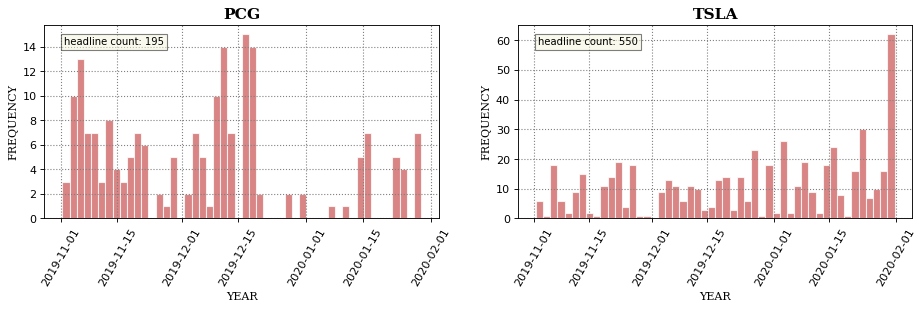

In [14]:
# put our chosen ticker names in a list:  
ticker_list = ['PCG', 'TSLA']

# create a list with 2 dataframes, each with the headlines for our 2 tickers: 
headlines_data = [select_ticker(x) for x in ticker_list]

# select a time scale
startDate = '2019-11-01'
endDate = '2020-02-01'

# plot a histogram for each
ticker_histogram(headlines_data, ticker_list, startDate, endDate)

# drop 'stock' column - not needed now:
headlines_data = [headlines_data[x].drop(['stock'], axis=1) for x in range(len(headlines_data))]

# filter for start and end dates:
headlines_data=set_date_range(headlines_data, startDate, endDate)

### Step 2: retrieve stock data
Now that we have our financial news headlines prepared, it is time to get hold of the stock price data for these two stocks for the same time period. Here we use Pandas Datareader's ```get_yahoo_data()```. We then have a look at them: 

In [15]:
def getStockData(ticker_list, start, end):
    stock_data = [] 
    for ticker in ticker_list:
        x = pdr.get_data_yahoo(ticker, start, end) 
        stock_data.append(x)
    return stock_data

# grab stock data:
stock_data = getStockData(ticker_list, startDate, endDate)

Let's examine the format of the stock data for one of the tickers:

In [16]:
stock_data[0].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-01,6.75,6.24,6.42,6.43,25562100,6.43
2019-11-04,7.83,6.60,6.65,7.27,46564100,7.27
2019-11-05,8.20,7.52,7.75,8.00,37076800,8.00
2019-11-06,7.70,6.49,7.65,6.92,24278500,6.92
2019-11-07,6.89,5.83,6.49,6.02,25419000,6.02


We're going to use the *close* column only. Therefore let's drop the other columns: 

In [17]:
stock_data = [stock_data[x].drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], 
                                 axis=1) for x in range(len(stock_data))]

Let's visualise the stock data for the two tickers (we view them as % change rather than absolute price so that we can view them together on the same scale): 

<Figure size 432x288 with 0 Axes>

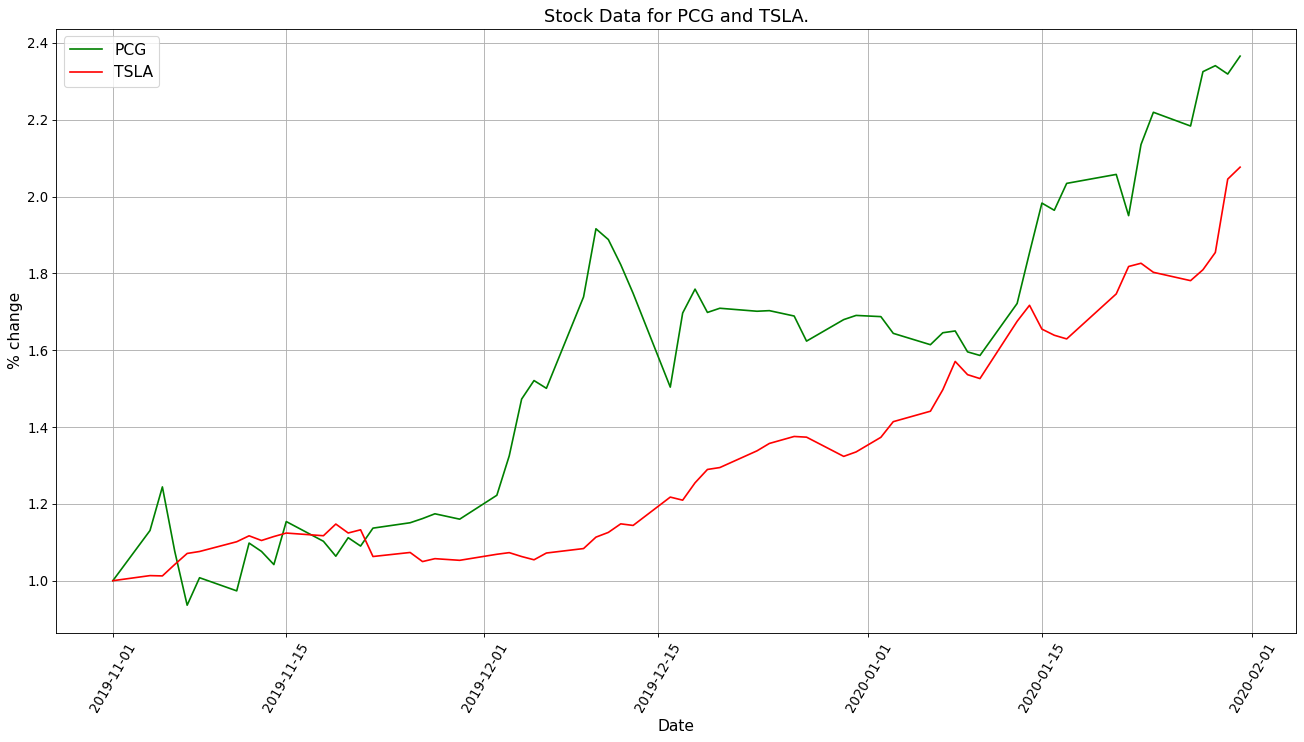

In [18]:
def plot_stock_data(data, tickers):
    plt.clf()
    plt.figure(figsize=(20, 10), dpi=80)
    # divide each stock by its first price to look at the changes         
    plt.plot(data[0]['Close']/data[0]['Close'].iloc[0], color='green')
    plt.plot(data[1]['Close']/data[1]['Close'].iloc[0], color='red')
    
    # decorative
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('% change', fontsize=14)
    plt.xticks(rotation='60', fontsize=12)
    plt.yticks(fontsize=12)    
    plt.title('Stock Data for {ticker0} and {ticker1}.'.format(ticker0=tickers[0], 
                                                                 ticker1=tickers[1]), fontsize=16)
    plt.legend([tickers[0], tickers[1]], fontsize=14)    
    plt.grid()
    
    plt.show()

plot_stock_data(stock_data, ticker_list)

### Step 3: Pre-processing
Stock markets operate between certain times e.g. our chosen tickers are listed on NASDAQ or NYSE, which trade between 9.30 a.m. and 4 p.m. Thus, a headline that is published at, say, 9 p.m. on a Friday could have no effect on trading till Monday at the earliest. Here we do a little pre-processing and assign the headlines to the correct day. Since the published times of the headlines have been set to UTC (GMT), rather than  US Eastern Time (ET), we adjust the open/close times in our ```get_trade_days()``` function to UTC-5hrs, that is, 13:30/20:00. (We ignore  daylight saving times). Pandas allows us to find the next business day with its module ```Bday```.  

In [19]:
def get_trade_days(date):       
    # Get the business day the article was published. I.e. take today's date, set the time to the open/close times
    # of the stock exchange. Then use BDay to ensure it is a business day. If not change the date to the next one.   
    today_open = date.floor('d').replace(hour=13,minute=30) - BDay(0)
    today_close = date.floor('d').replace(hour=20,minute=0) - BDay(0)  
    # establish the previous and next business days accordingly: 
    yesterday_close = today_open - BDay()
    tomorrow_open = today_close + BDay()
    
    # if the article was published between yesterday's close and today's close, we assign it today's date
    if ((date>=yesterday_close) & (date<today_close)):
        return today_open 
    else: # otherwise it is assigned the next business day
        return tomorrow_open
       
    
def set_trade_days(data):
    data['date'] = data['date'].apply(get_trade_days)
    data['date'] = pd.to_datetime(pd.to_datetime(data['date']).dt.date)
    return data

headlines_data = [set_trade_days(x) for x in headlines_data]

### Step 4: Sentiment analysis on headlines
It is now time to find the sentiment of the headlines. Common non-machine learning algorithms for sentiment analysis include Vader and Textblob, but here we instead use a pre-trained deep learning model, [FinBERT](https://huggingface.co/ProsusAI/finbert), which is based on the deep learning natural-language processing algorithm BERT and fine-tuned on financial text. We implement it here using the ```pipeline``` module that is included in the ```Transformers``` library. 

The below two functions will allow us to send each headline to FinBERT and it will return us three scores for each headline: a positive, a negative and neutral, each representing a probability between 0 and 1, and all summing up to 1. In order to create a positive/negative polarity score, we simply subtract negative from positive. This results in a range of possible scores for each headline of -1 (most negative) to +1 (most positive). We store the algorithms output (which is the three scores) in a new column of each ticker's dataframe, called *sentiment*, and store the polarity score, which we derive in the first function below, in another column called *sentiment_f*:   

In [20]:
def parse_sentiment_score(lst):
    dicarray = np.squeeze(np.array(lst))
    pos_dic = next(filter(lambda x: x['label'] == 'positive', dicarray))
    pos = pos_dic['score']
    neg_dic = next(filter(lambda x: x['label'] == 'negative', dicarray))
    neg = neg_dic['score']
    neu_dic = next(filter(lambda x: x['label'] == 'neutral', dicarray))
    neu = neu_dic['score'] 
    result = pos-neg
    return result


def get_sentiment_finbert(data):
    model_name = "ProsusAI/finbert"
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True) # 'sentiment-analysis' is the pipeline type
    data = (
        data
        .assign(sentiment = lambda x: x['title'].apply(lambda s: classifier(s)))
        .assign(sentiment_f = lambda x: x['sentiment'].apply(parse_sentiment_score))
    )
    return data

In [22]:
headlines_data = [get_sentiment_finbert(x) for x in headlines_data]

Let's have a look at one of the results: 

In [23]:
headlines_data[0].iloc[1]['sentiment']

[[{'label': 'positive', 'score': 0.9170737862586975},
  {'label': 'negative', 'score': 0.011352918110787868},
  {'label': 'neutral', 'score': 0.07157319784164429}]]

In [24]:
headlines_data[0].iloc[1]['sentiment_f']

0.9057208681479096

We can now drop the *sentiment* column, as it is no longer needed: 

In [25]:
headlines_data = [headlines_data[x].drop(['sentiment'], axis=1) for x in range(len(headlines_data))]

All this gives us a sentiment score for each headline. However, there may be multiple headlines (or none) on any given day. Therefore, we take the *mean* sentiment score for each day: 

In [26]:
grouped_dates = [headlines_data[x].groupby(['date']) for x in range(len(headlines_data))]
sentiments_data = [x.mean() for x in grouped_dates]

For days with no headlines, we will get NaNs. So we impute these with a score of 0. As we do this, it will be helpful to combine our stock and sentiment data for each ticker into a single dataframe, which will then be stored in a list called *two_time_series*:

In [27]:
two_time_series = [pd.merge(stock_data[x], sentiments_data[x], left_index=True, right_index=True, how='left')
                   .fillna(0) for x in range( len(stock_data ))]

Let's now plot the sentiment just to have a look at the distribution of negative to positive headlines over the period for each ticker:

In [29]:
def plot_sentiment(lst):
    plt.clf()
    fig = plt.figure(figsize=(16, 8), dpi=80, facecolor='white')
    spec = gridspec.GridSpec(ncols = 1, nrows = 2)
    ax=[]
    counter = 0
    
    for df in lst:
        ticker_name = ticker_list[counter]
        # create axis
        if counter==0:
            ax.append(fig.add_subplot(spec[counter])) 
            plt.tick_params('x', labelbottom=False)
        else:
            ax.append(fig.add_subplot(spec[counter], sharex=ax[0]))
            ax[counter].set_xlabel('Date', fontsize=14)            
        
        # sntiment bars: make the negative values red, and the positive/neutrals green:
        mask1=df['sentiment_f'][df['sentiment_f']<0]
        mask2=df['sentiment_f'][df['sentiment_f']>=0]
        ax[counter].bar(mask1[:].index, mask1[:], facecolor='indianred', alpha=0.75)
        ax[counter].bar(mask2[:].index, mask2[:], facecolor='mediumaquamarine', alpha=0.75)        
        
        # axis labels and title
        ax[counter].set_title("Sentiment score for {ticker_name}".format(ticker_name=ticker_name), fontsize=16)
        ax[counter].set_ylabel('Score', fontsize=14)
        ax[counter].tick_params(axis='x', labelrotation=60)
        ax[counter].xaxis.set_major_locator(plt.MaxNLocator(10))
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)    

        ax[counter].grid(b=True, which='major', color='gray', alpha=1.0, linestyle='--')
        ax[counter].grid(b=True, which='minor', color='indianred', alpha=0.4, linestyle='--')
        ax[counter].minorticks_on()
        # a bit of scaling 
        ax[counter].set_ylim(min(df['sentiment_f'])-.1, max(df['sentiment_f'])+.1)

        counter = counter+1 
            
    fig.tight_layout()
    plt.show()



<Figure size 432x288 with 0 Axes>

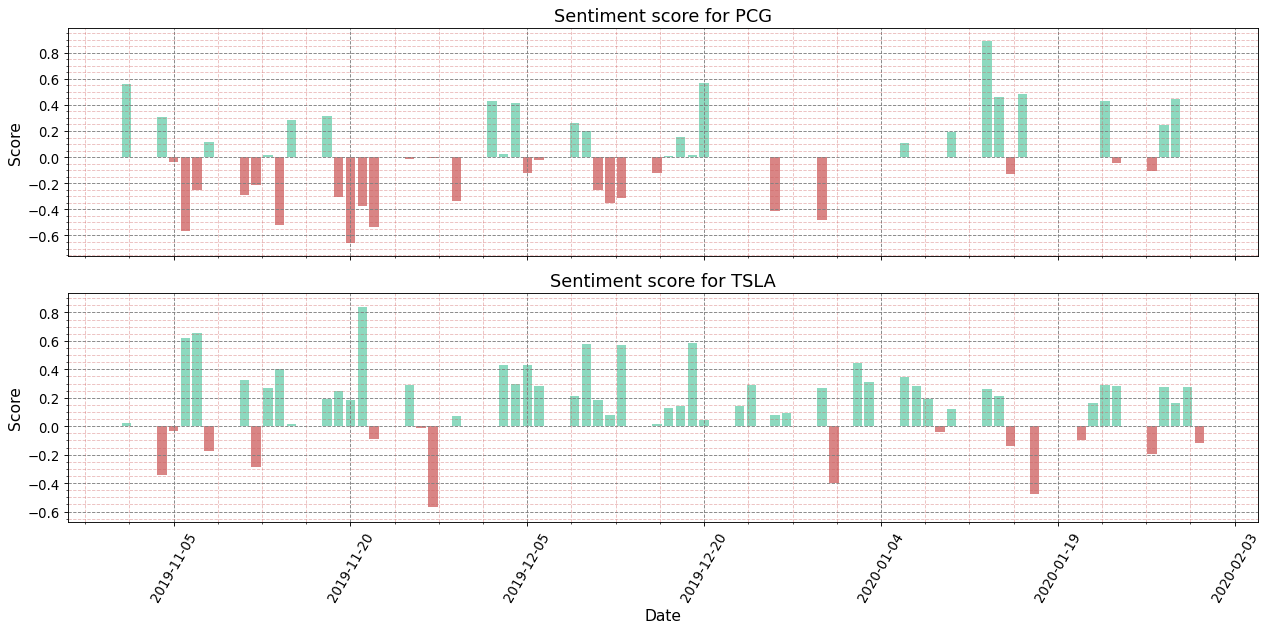

In [30]:
plot_sentiment(two_time_series)

### Step 5: Statistical analysis

### Tests for stationarity

We now want to see if there is any correlation between sentiment and stock price over the time period we have selected. It's not obvious from visually comparing sentiment scores with stock price changes whether or not they correlate. Furthermore, we need to avoid 'spurious' correlations i.e. mistakenly seeing correlations in time series that do not exist.  

Hence we will ensure our time series are *stationary*. That is, we will need to ensure each has a consistent mean and variance, and have removed any trend or seasonality. In what follows we shall make use the Python library ```statsmodels.tsa.stattools```. One test for stationarity is the *Augmented Dickey-Fuller (ADF) test*, which we shall run our two time series by:    


In [31]:
def ADF_test(df):
    print(adfuller(df))
    
ADF_test(two_time_series[0]['Close'])
ADF_test(two_time_series[0]['sentiment_f']) 

ADF_test(two_time_series[1]['Close'])
ADF_test(two_time_series[1]['sentiment_f']) 

(-0.3153094492982783, 0.9233078948430622, 0, 61, {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}, 86.00766715869301)
(-6.146422952636766, 7.747481063956256e-08, 0, 61, {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}, 20.149084624842402)
(2.5291660858731784, 0.9990586559508666, 3, 58, {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}, 248.09364042208762)
(-7.697903715582589, 1.3636980611351953e-11, 0, 61, {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}, 9.922157635318271)


The first value in each output is the *test statistic*, which is what we are interested in. The more negative this is, the more likely the series is stationary. We can compare this value to value listed as '5%' in the dictionary that is also returned for each time series above. Looking closely, we see that 2 of the 4 time series have a test stastic that is larger than the associated 5% level. The two series in question are the stock price data for each ticker. Hence, they fail the test and are not stationary. 

Another test we can do is a test to see if the time series are autocorrelated i.e. correlated with themselves. This test compares each series to itself offset by a lag k, for various values of k. To do this we use the autocorrelation function (ACF): ```stattools.graphics.tsaplots.plot_acf```: 

In [33]:
def plot_autocorrelation(df):
    plt.clf()
    fig = plt.figure(figsize=(9, 12), dpi=80, facecolor='white')
    spec = gridspec.GridSpec(ncols = 2, nrows = 4) # create 2 rows x 4 column figure 
    global ax
    ax=[]
    counter = 0
    ticker=0
    
    for i in df:        
        ticker_name = ticker_list[ticker]
        for j in range(0,2):
            # create axes 
            if counter==0:
                ax.append(fig.add_subplot(spec[counter]))	
                
            else:
                ax.append(fig.add_subplot(spec[counter], sharex=ax[0]))
            # create plot
            if j==0: # alpha=0.05 means 95% CI
                plot_acf(i['Close'], lags=20, alpha=0.05, zero=True, title=None, ax=ax[counter], 
                         color="navy", markersize=3, linewidth=1, vlines_kwargs={"colors": "black", "linewidth": .8})    
            else:
                plot_acf(i['sentiment_f'], lags=20, alpha=0.05, zero=True, title=None, ax=ax[counter], 
                         color="navy", markersize=3, linewidth=1, vlines_kwargs={"colors": "black", "linewidth": .8})
            # decoration 
            ax[counter].legend([ticker_name], loc="upper right", fontsize=10, framealpha=1, edgecolor="black", shadow=None)
            ax[counter].grid(which="major", color="grey", linestyle="--", linewidth=0.5)
            if (counter==0):
                ax[counter].set_title("Stocks autocorrelation", family='serif', fontsize=12, 
                                      fontweight='bold')
            elif (counter==1):
                ax[counter].set_title("Sentiment autocorrelation", family='serif', fontsize=12, 
                                      fontweight='bold')
                
            counter=counter+1
            
        ticker=ticker+1
            
    fig.tight_layout()
    plt.show()


<Figure size 432x288 with 0 Axes>

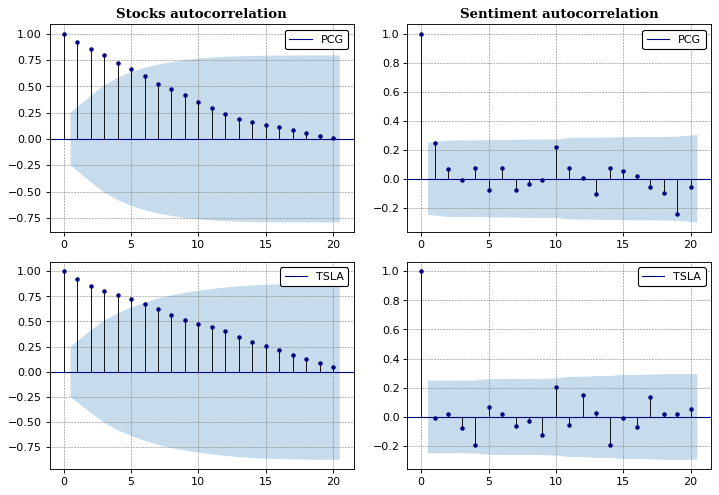

In [34]:
plot_autocorrelation(two_time_series)

If the ACF values (listed on the y-axis) lie outside of the shaded areas then they are deemed significant. We see that stock prices are indeed correlated with themselves up to about a lag of 5 days. The sentiment scores are, by contrast, stationary. (We discount the lag of 0 since all series will be perfectly correlated with themselves at the same point in time). 

How do we make the stock data stationary? A common approach is to do a little feature engineering on the non-stationary series by taking the difference between a data point in the series and the previous data point (i.e. xdiff<sub>t</sub> = x<sub>t</sub> - x<sub>(t-1)</sub>). We'll do this for the two stock price series, and then plot the result: 

In [35]:
def take_difference(df):
    df_tmp = df.diff().dropna()
    return df_tmp


def plot_take_difference(df):
    plt.clf()
    fig = plt.figure(figsize=(14, 20), dpi=80, facecolor='white')
    spec = gridspec.GridSpec(ncols = 2, nrows = 4) # create 2 rows x 4 column figure 
    ax=[]
    fig.tight_layout()
    counter = 0
    ticker=0
    
    for i in df:        
        ticker_name = ticker_list[ticker]
        for j in range(0,2):
  
            if counter==0:
                ax.append(fig.add_subplot(spec[counter]))	                
            else:
                ax.append(fig.add_subplot(spec[counter], sharex=ax[0]))            
            if j==0:
                z = i['Close'].dropna()
                z.plot(linewidth=1, color='red')       

            else:                 
                z = i['Close'].diff().dropna()                
                z.plot(linewidth=1, color='limegreen')         
           
            ax[counter].legend([ticker_name], loc="upper left", fontsize=10, framealpha=1, edgecolor="black", shadow=None)
            ax[counter].grid(which="major", color="grey", linestyle="--", linewidth=0.5)
            if (counter==0):
                ax[counter].set_title("Stocks: BEFORE (non-stationary)", family='serif', fontsize=12, 
                                      fontweight='bold', pad=20)
            elif (counter==1):
                ax[counter].set_title("Stocks: AFTER (stationary)", family='serif', fontsize=12, 
                                      fontweight='bold', pad=20)
            plt.xlabel('Time', family='serif', fontsize=12)
            plt.xticks(rotation='60', fontsize=10)
            plt.yticks(fontsize=10)
            counter=counter+1
            
        ticker=ticker+1
            
    
    plt.show()
    return df

<Figure size 432x288 with 0 Axes>

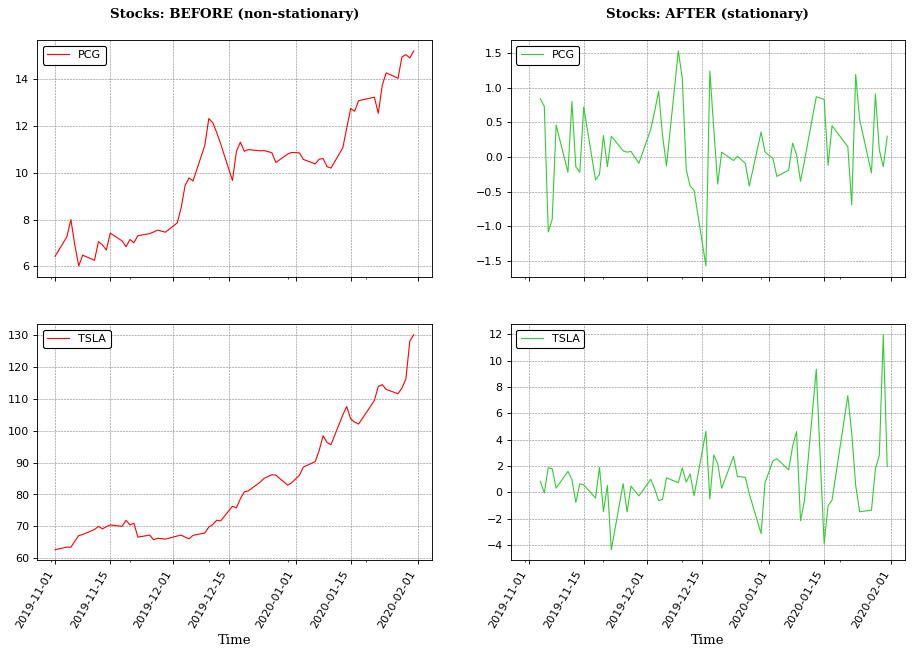

In [36]:
plot_take_difference(two_time_series)
two_time_series_stationary=[take_difference(x) for x in two_time_series]

The right-hand side plots show the result of taking the difference. We see that the trend has been removed and that the mean and variance are consistent over time now. 

We also see the two stock time series, after differencing, now pass the ADF test if we run it again: 

In [37]:
# ---------------------------------
# 2b. Re-test for stationarity
# ---------------------------------
ADF_test(two_time_series_stationary[0]['Close'])
ADF_test(two_time_series_stationary[1]['Close'])

(-7.340909886097775, 1.0658304621949105e-10, 0, 60, {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}, 84.84479198462247)
(-6.611586355314544, 6.357080919714013e-09, 0, 60, {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}, 247.36002719824717)


As can be seen, the test statistics are now smaller than the 5% critical value. 

### Tests for cross correlation
 
At last, we can now see if they correlate at all (at least over this time period) by using the ```stattools``` function ```ccf```. We can then create a plot to show this. Python does have a function to plot cross correlation, namely ```matplotlib.pyplot.xcorr```, but it does not plot cross-correlation in quite the way R does: it does not allow us to view negative lags, nor the 95% confidence interval lines. We therefore do a bit of tinkering to manually recreate R's visuals in a ```stem``` plot from ```matplotlib``` in the below function:

In [38]:
def plot_cross_correlation(df):
    plt.clf()
    fig = plt.figure(figsize=(12, 8), dpi=80, facecolor='white')
    spec = gridspec.GridSpec(ncols = 2, nrows = 2)
    ax=[]
    ticker=0
    counter = 0
    
    for i in df:
        # create axis
        ax.append(fig.add_subplot(spec[counter]))
        
        #Get data
        x=i['Close']
        y=i['sentiment_f']
        
        # some variables to help 
        n = len(x) # number of samples         
        lags = round(10*math.log10(n/2)) # number of lags (same formula R uses apparently). 
                                            # 2 is the number of series we are comparing, which is 2. 
        slice_value = n-lags
        
        # calculate positive and negative values for cross-correlation:  
        backwards = stattools.ccf(x[::-1], y[::-1], adjusted=False)[::-1]
        forwards = stattools.ccf(x, y, adjusted=False)
        cross_cor_result = np.r_[backwards[:-1], forwards][slice_value:][:-slice_value]
        
        # draw plot and CI lines: 
        _, stemlines, _ = ax[counter].stem(range(-len(cross_cor_result)//2+1, len(cross_cor_result)//2+1), 
                         cross_cor_result, linefmt='-', markerfmt=" ", basefmt=" ")
        ax[counter].axhline(-1.96/np.sqrt(n), color='b', ls='--', linewidth=1., alpha=0.75) 
        ax[counter].axhline(1.96/np.sqrt(n), color='b', ls='--', linewidth=1., alpha=0.75)
        ax[counter].axhline(0, color='k', ls='-')
        plt.setp(stemlines, 'linewidth', 1., color='k')
        
        # subplot text: 
        ticker_name = ticker_list[counter] 
        ax[counter].set_title(ticker_name)
        ax[counter].set_xlabel('Lags')
        ax[counter].set_ylabel('Cross correlation')
        
        counter = counter+1  
    
    # figure text: 
    plt.suptitle("Stock vs Sentiment cross-correlations")
    fig.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

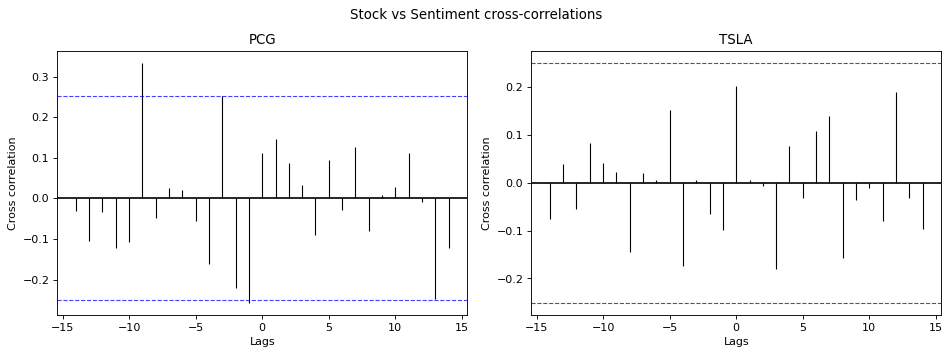

In [23]:
plot_cross_correlation(two_time_series_stationary)

### Conclusion 

The blue lines are the confidence interval. Where the stems pertrude outside of the confidence interval, the correlation is held to be significent. Here the plot suggests some negative correlation for PCG for this time period, but mainly at a significant lag. We find none for TSLA. Further analysis would be required to form any firmer conclusions, including whether this pattern holds for these tickers at different time periods or window sizes in time, or whether different tickers have any correlation. 
